# 幺（Yao）
We introduce Yao, an <span style="color:#33AA77">extensible</span>, <span style="color:#33AA77">efficient</span> **open source** **Julia** package for
circuit based quantum simulation. It is inspired by **variational** quantum algorithms.
<img src="images/logo_small.png" width=300/>

How to find 幺:
https://github.com/QuantumBFS/Yao.jl

How to find this tutorial:
https://github.com/GiggleLiu/YaoTutorial

Where to learn quantum algorithms:
https://github.com/QuantumBFS/QuAlgorithmZoo.jl

# Circuit based Quantum softwares

<img src="images/fullstack.png" width=1000/>
arXiv:1812.09167

# We need open source quantum softwares
"Open source software in quantum computing"

arXiv: 1812.09167, arXiv: 1902.00991

![image.png](images/packagelist1.png)

![image.png](images/packagelist2.png)

# Why Yao?

# Variational Quantum Algorithms, e.g. Quantum Machine Learning
arXiv:1906.07682
![image.png](images/valg.png)

# Challenges to softwares
* Gradient based training
* Parameter management
* **Small to intermediate size circuit performance**

![image.png](images/mlqc_review.png)
arXiv:1906.07682

Note: qulacs is also a good open source variationlal quantum simulator https://github.com/qulacs/qulacs

# The complexity of obtaining the gradient is $O(M^2)$

Here, $M$ is the number of parameters.

In paper: "Variational quantum eigensolver with fewer qubits" (arXiv:1902.02663)
![image.png](images/qmps.png)

![image.png](images/gatecount.png)

### For M = 1000
**SQUID**: 100ns per gate, 11.5 days

**CPU**: 3GHz, 2.4 days (assume 6 qubits can be simulated with 64 operations, parallelism is not considered)

**GPU**: 1GHz, 3000 threads, 3.6 min (NOTE! this is theoretical, in practise, it is more than 24 hours)

# A benchmark
![benchmark](images/qulacs_benchmark.png)

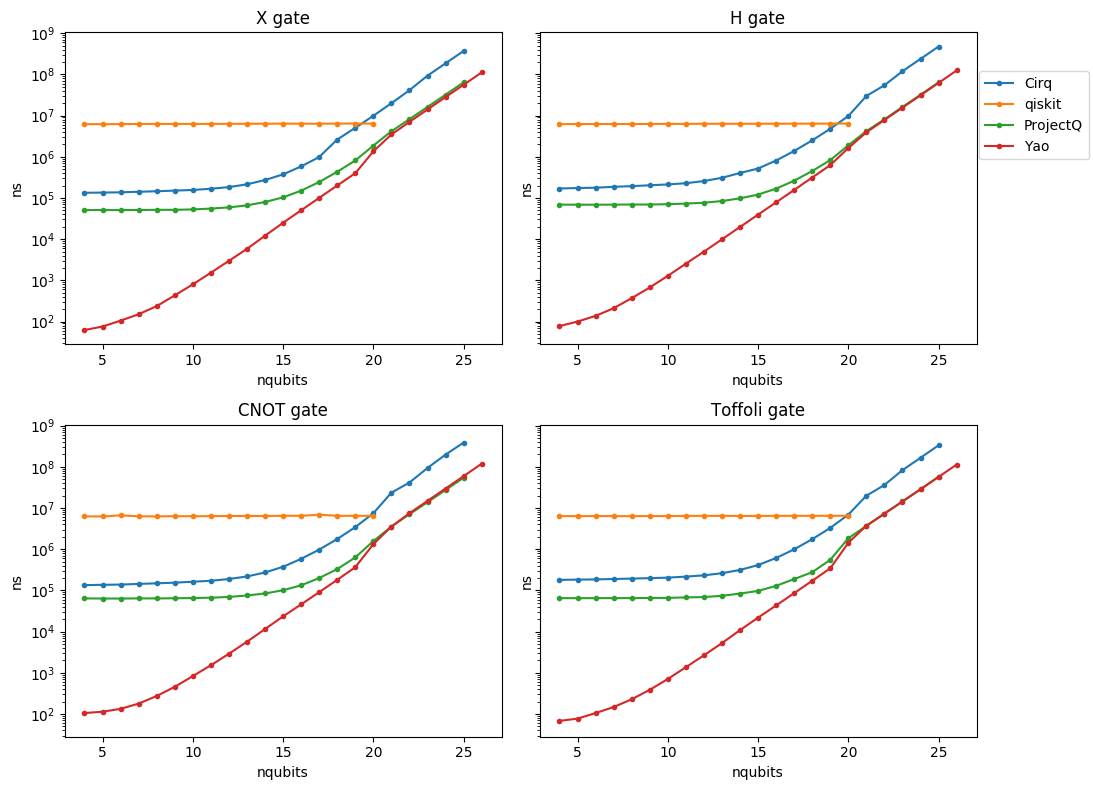

# GPU performance (not batched)
<img src="images/cudabench.png" width=800/>

# Yao stack: not all about performance
![yaoarch](images/yaoarch.png)

# Live coding:

summarized in "handson.jl"

**Example 1**: construct a random wave function, apply QFT algorithm on qubits "4,5,6,7".

**Example 2**: construct a 20 qubit Heisenberg chain hamiltonian, apply imaginary time evolution and VQE.

# Construct a Hamiltonian

In [43]:
nbit = 8  # how many qubits do you expect?

sx(i) = put(nbit, i=>X)
sy(i) = put(nbit, i=>Y)
sz(i) = put(nbit, i=>Z)

hami = sum([sx(i)*sx(i+1)+sy(i) *sy(i+1)+sz(i)*sz(i+1) for i=1:nbit-1])

nqubits: 8
+
├─ +
│  ├─ chain
│  │  ├─ put on (2)
│  │  │  └─ X gate
│  │  └─ put on (1)
│  │     └─ X gate
│  ├─ chain
│  │  ├─ put on (2)
│  │  │  └─ Y gate
│  │  └─ put on (1)
│  │     └─ Y gate
│  └─ chain
│     ├─ put on (2)
│     │  └─ Z gate
│     └─ put on (1)
│        └─ Z gate
├─ +
│  ├─ chain
│  │  ├─ put on (3)
│  │  │  └─ X gate
│  │  └─ put on (2)
│  │     └─ X gate
│  ├─ chain
│  │  ├─ put on (3)
│  │  │  └─ Y gate
│  │  └─ put on (2)
│  │     └─ Y gate
│  └─ chain
│     ├─ put on (3)
│     │  └─ Z gate
│     └─ put on (2)
│        └─ Z gate
├─ +
│  ├─ chain
│  │  ├─ put on (4)
│  │  │  └─ X gate
│  │  └─ put on (3)
│  │     └─ X gate
│  ├─ chain
│  │  ├─ put on (4)
│  │  │  └─ Y gate
│  │  └─ put on (3)
│  │     └─ Y gate
│  └─ chain
│     ├─ put on (4)
│     │  └─ Z gate
│     └─ put on (3)
│        └─ Z gate
├─ +
│  ├─ chain
│  │  ├─ put on (5)
│  │  │  └─ X gate
│  │  └─ put on (4)
│  │     └─ X gate
│  ├─ chain
│  │  ├─ put on (5)
│  │  │  └─ Y gate
│  │  └─ put on 

# Wave function ansatz

In [56]:
dc = random_diff_circuit(nbit)

# tag differentiable nodes
dc = dc |> autodiff(:BP)

# parameter management
dispatch!(dc, :random)

# get wave function
out = zero_state(nbit) |> dc

# get the expectation values of hamiltonian
expect(hami, out)

0.6941393762197795 - 1.0408340855860843e-17im

# The training

In [64]:
# get the gradient
∇out = copy(out) |> hami
backward!((copy(out), ∇out), dc)
grad = gradient(dc)

# gradient descent
dispatch!(-, dc, grad*0.1);

expect(hami, zero_state(nbit) |> dc)

-0.6598237891223008 + 4.5102810375396984e-17im

# FAQ: why Julia

# **Performance**
Solving two language problem

* **ProjectQ**: C++ (pybind) python
* **Quest**: Pure C
* **Qulacs**: C++ (and) python

# GPU version swap instruction

In [41]:
function instruct!(reg::ArrayReg{B,<:CuArrays}, ::Val{:SWAP}, locs::Tuple{Int,Int}) where {B}
    b1, b2 = locs
    state = statevec(reg)
    mask1 = bmask(b1)
    mask2 = bmask(b2)

    # note: this kernel does not have the best performance,
    # shared memory + `shfl_xor` will probably increase the memory access performance.
    function kf(state, mask1, mask2)
        inds = ((blockIdx().x-1) * blockDim().x + threadIdx().x,
        (blockIdx().y-1) * blockDim().y + threadIdx().y)
        b = inds[1]-1
        c = inds[2]
        c <= size(state, 2) || return nothing
        if b&mask1==0 && b&mask2==mask2
            i = b+1
            i_ = b ⊻ (mask1|mask2) + 1
            temp = state[i, c]
            state[i, c] = state[i_, c]
            state[i_, c] = temp
        end
        nothing
    end
    X, Y = cudiv(size(state)...)
    @cuda threads=X blocks=Y kf(state, mask1, mask2)
    state
end

LoadError: UndefVarError: @cuda not defined

# Back propagation in QC

![image.png](images/wavebp.png)

# differentiate over matrix representation

![image.png](images/zygote-yao.png)
arXiv:1907.07587

# How to Learn Yao.jl
### Read the documentation

https://quantumbfs.github.io/Yao.jl/latest

### 关注我的知乎专栏 “和Leo一起学量子编程”
https://zhuanlan.zhihu.com/quantumcoding

### Quantum Algorithm Zoo
https://github.com/QuantumBFS/QuAlgorithmZoo.jl

# How to contribute to an open source project
### File an issue
* https://github.com/QuantumBFS/Yao.jl/issues/new

### Give us pull requests
* Documentation
* Writing tests
* ...